In [48]:
import numpy as np
from recordlinkage.base import BaseCompareFeature

class JaccardSimilarity(BaseCompareFeature):
    
    def _compute_vectorized(self, strings1, strings2):
        set1 = np.array([set(string) for string in strings1])
        set2 = np.array([set(string) for string in strings2])
    
        intersection = np.array([len(s1 & s2) for s1, s2 in zip(set1, set2)])
        union = np.array([len(s1 | s2) for s1, s2 in zip(set1, set2)])
    
        jaccard_similarity = intersection / union
        jaccard_similarity[np.isnan(jaccard_similarity)] = 0
    
        return pd.DataFrame(jaccard_similarity, columns=["Jaccard Similarity"])
    

In [207]:
import numpy as np

def generate_candidate_pairs(index1, index2=None):
    if index2 != None:
        combinations = np.transpose([np.tile(index1, len(index2)), np.repeat(index2, len(index1))])
        return combinations.tolist()
    else:
        combinations = np.array(np.meshgrid(index1, index1)).T.reshape(-1, 2) # Generate every combinations
        unique_combinations = combinations[combinations[:, 0] < combinations[:, 1]] # Select only unique combinations
        return unique_combinations.tolist()
        
def generate_true_matches(df):
    candidate_pairs = []
    for i, group in df.groupby("cluster"): # Groups record matches
        if group.shape[0]>1:
            candidate_pair = generate_candidate_pairs(group.index) # Generate pairs
            candidate_pairs.append(candidate_pair)
    candidate_pairs = np.array(candidate_pairs).reshape(-1,2).T
    return pd.MultiIndex.from_arrays(candidate_pairs, names=('rec_1', 'rec_2'))

In [156]:
from recordlinkage.datasets import load_febrl3
df, true_links = load_febrl3(True)

In [157]:
import recordlinkage
from recordlinkage.index import Block

indexer = recordlinkage.Index([
    Block("date_of_birth")
])

candidate_pairs = indexer.index(df)

In [201]:
from recordlinkage.compare import String

comparer = recordlinkage.Compare([
    String("given_name", "given_name", method="jarowinkler", label="given_name"),
    String("surname", "surname", method="jarowinkler", label="surname"),
    String("soc_sec_id", "soc_sec_id", method="jarowinkler", label="soc_sec_id"),
    String("address_1", "address_1", method="jarowinkler", label="address_1"),
])

comparison_vector = comparer.compute(candidate_pairs, df)

In [202]:
len(comparison_vector)

5966

In [203]:
ecm = recordlinkage.ECMClassifier(binarize=0.1)

pred_links = ecm.fit_predict(comparison_vector)

In [204]:
len(pred_links)

5836

<Axes: ylabel='Frequency'>

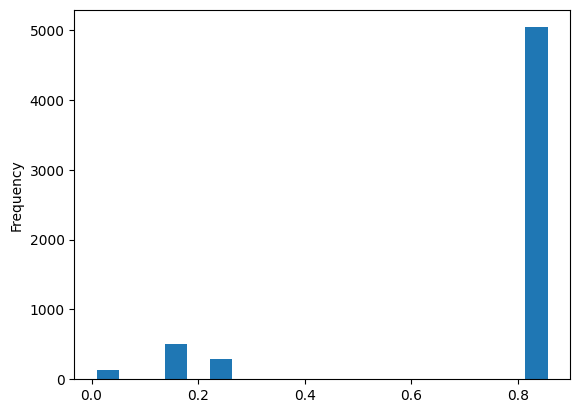

In [200]:
ecm.prob(comparison_vector).plot.hist(bins=20)